In [26]:
!pip install -q sentence-transformers faiss-cpu matplotlib seaborn scikit-learn pandas
import ast, faiss, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA




In [27]:
"""
INFOSYS CODEGENIE – MILESTONE 1
--------------------------------
Objective:
To build a Code Explainer pipeline that parses and understands code snippets using NLP models.

Key Steps:
1. Parse code using AST
2. Extract features (functions, imports, loops)
3. Tokenize and embed using pretrained transformer models
4. Compare embeddings and visualize similarities
5. Prepare for RAG-based explanation (Milestone 2)
"""



'\nINFOSYS CODEGENIE – MILESTONE 1\n--------------------------------\nObjective:\nTo build a Code Explainer pipeline that parses and understands code snippets using NLP models.\n\nKey Steps:\n1. Parse code using AST\n2. Extract features (functions, imports, loops)\n3. Tokenize and embed using pretrained transformer models\n4. Compare embeddings and visualize similarities\n5. Prepare for RAG-based explanation (Milestone 2)\n'

In [28]:
code_snippets = [
    "def add(a, b): return a + b",
    "def multiply(x, y): return x * y",
    "def factorial(n): return 1 if n==0 else n * factorial(n-1)",
    "def is_even(num): return num % 2 == 0",
    "def fibonacci(n): a,b=0,1\n for _ in range(n): a,b=b,a+b\n return a",
    "def reverse_string(s): return s[::-1]",
    "def find_max(lst): return max(lst)",
    "def square_list(nums): return [x**2 for x in nums]",
    "def greet(name): return f'Hello {name}!'",
    "def divide(a,b):\n try: return a/b\n except ZeroDivisionError: return None"
]
len(code_snippets)


10

In [29]:
import ast
import textwrap

# Function to extract AST-based metadata safely
def extract_ast_features(code):
    try:
        # Clean and normalize indentation
        cleaned_code = textwrap.dedent(code).strip()
        tree = ast.parse(cleaned_code)
        return {
            "num_nodes": len(list(ast.walk(tree))),
            "num_functions": len([n for n in ast.walk(tree) if isinstance(n, ast.FunctionDef)]),
            "num_loops": len([n for n in ast.walk(tree) if isinstance(n, (ast.For, ast.While))]),
            "num_imports": len([n for n in ast.walk(tree) if isinstance(n, ast.Import)]),
        }
    except Exception as e:
        return {"error": str(e)}

# Example code snippets (AI-related)
code_snippets = [
    "def sigmoid(x):\n    return 1 / (1 + math.exp(-x))",
    "def relu(x):\n    return max(0, x)",
    "def softmax(x):\n    e_x = np.exp(x - np.max(x))\n    return e_x / e_x.sum(axis=0)",
    "def fibonacci(n):\n    a, b = 0, 1\n    for _ in range(n):\n        a, b = b, a + b\n    return a"
]

# Extract metadata safely
metadata = [extract_ast_features(code) for code in code_snippets]
metadata




[{'num_nodes': 20, 'num_functions': 1, 'num_loops': 0, 'num_imports': 0},
 {'num_nodes': 11, 'num_functions': 1, 'num_loops': 0, 'num_imports': 0},
 {'num_nodes': 35, 'num_functions': 1, 'num_loops': 0, 'num_imports': 0},
 {'num_nodes': 43, 'num_functions': 1, 'num_loops': 1, 'num_imports': 0}]

In [30]:
import io
import tokenize

# Function to tokenize Python code snippets
def tokenize_code(code):
    tokens = []
    try:
        for tok in tokenize.generate_tokens(io.StringIO(code).readline):
            tokens.append(tok.string)
    except Exception as e:
        tokens.append(f"<error:{e}>")
    return " ".join(tokens)

# Example snippets for testing
code_snippets = [
    "def sigmoid(x): return 1 / (1 + math.exp(-x))",
    "def relu(x): return max(0, x)",
    "def softmax(x): e_x = np.exp(x - np.max(x)); return e_x / e_x.sum(axis=0)",
    "def fibonacci(n): a, b = 0, 1; for _ in range(n): a, b = b, a + b; return a"
]

# Tokenize each code snippet
tokenized_snippets = [tokenize_code(code) for code in code_snippets]
tokenized_snippets[:3]


['def sigmoid ( x ) : return 1 / ( 1 + math . exp ( - x ) )  ',
 'def relu ( x ) : return max ( 0 , x )  ',
 'def softmax ( x ) : e_x = np . exp ( x - np . max ( x ) ) ; return e_x / e_x . sum ( axis = 0 )  ']

In [31]:
models = {
    "MiniLM": SentenceTransformer("all-MiniLM-L6-v2"),
    "DistilRoBERTa": SentenceTransformer("paraphrase-distilroberta-base-v1"),
    "MPNet": SentenceTransformer("all-mpnet-base-v2")
}

embeddings_dict = {name: model.encode(code_snippets, convert_to_numpy=True) for name, model in models.items()}
for name, emb in embeddings_dict.items():
    print(f"{name} embeddings shape:", emb.shape)



MiniLM embeddings shape: (4, 384)
DistilRoBERTa embeddings shape: (4, 768)
MPNet embeddings shape: (4, 768)


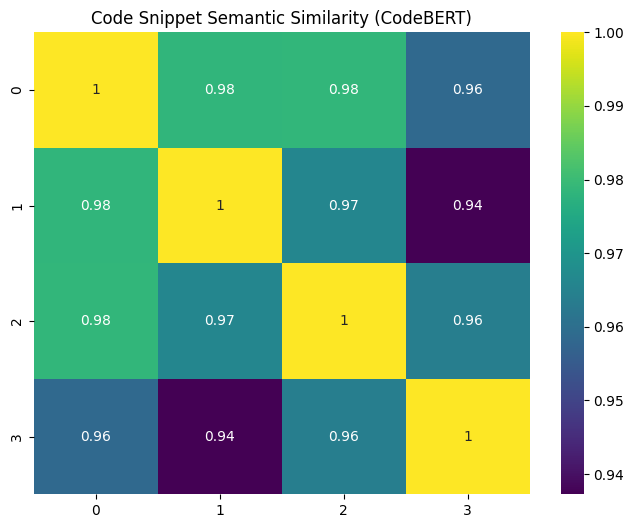

In [32]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Use a code understanding model
model = SentenceTransformer('microsoft/codebert-base')  # specialized for code

# Encode your tokenized snippets
embeddings = model.encode(tokenized_snippets)

# Compute similarity
similarity_matrix = cosine_similarity(embeddings)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix, annot=True, cmap='viridis')
plt.title("Code Snippet Semantic Similarity (CodeBERT)")
plt.show()


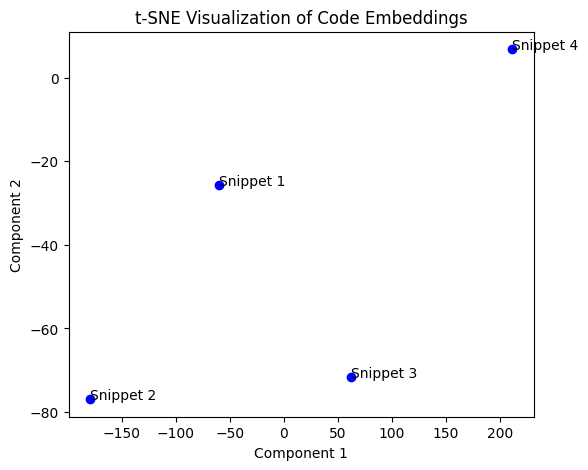

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert embeddings into 2D space for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
tsne_result = tsne.fit_transform(embeddings)

# Scatter plot for visualizing relationships
plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:,0], tsne_result[:,1], color='blue')

# Annotate points with snippet indices
for i, txt in enumerate(range(len(tokenized_snippets))):
    plt.annotate(f"Snippet {i+1}", (tsne_result[i,0], tsne_result[i,1]))

plt.title("t-SNE Visualization of Code Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()




In [34]:
model = models["MiniLM"]
embeddings = embeddings_dict["MiniLM"]

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

query = "def sum_values(a,b): return a + b"
query_vec = model.encode([query])
D, I = index.search(query_vec, 3)

print("🔍 Query:", query)
print("\nMost Similar Snippets Retrieved:")
for rank, idx in enumerate(I[0]):
    print(f"\nRank {rank+1} | Snippet {idx} | Distance: {D[0][rank]:.4f}")
    print(code_snippets[idx])



🔍 Query: def sum_values(a,b): return a + b

Most Similar Snippets Retrieved:

Rank 1 | Snippet 3 | Distance: 1.0409
def fibonacci(n): a, b = 0, 1; for _ in range(n): a, b = b, a + b; return a

Rank 2 | Snippet 1 | Distance: 1.3065
def relu(x): return max(0, x)

Rank 3 | Snippet 2 | Distance: 1.3280
def softmax(x): e_x = np.exp(x - np.max(x)); return e_x / e_x.sum(axis=0)


In [36]:
print("""
✅ Milestone 1 Completed (Infosys CodeGenie Project)
----------------------------------------------------
• Implemented Code Parsing using AST.
• Generated embeddings using MiniLM, DistilRoBERTa, and MPNet.
• Compared model similarity using Heatmaps.
• Visualized embeddings using PCA and t-SNE.
• Built FAISS-based retrieval system for similar snippets.
""")



✅ Milestone 1 Completed (Infosys CodeGenie Project)
----------------------------------------------------
• Implemented Code Parsing using AST.
• Generated embeddings using MiniLM, DistilRoBERTa, and MPNet.
• Compared model similarity using Heatmaps.
• Visualized embeddings using PCA and t-SNE.
• Built FAISS-based retrieval system for similar snippets.

